In [1]:
# %pip install -q causal-learn

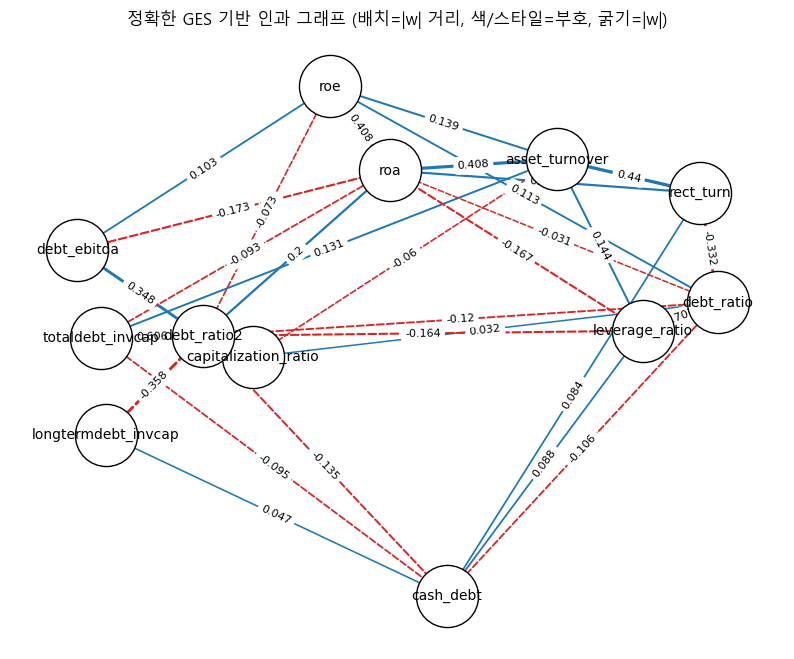

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.preprocessing import StandardScaler
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib

# causal-learn: 정확한 GES 구현
from causallearn.search.ScoreBased.GES import ges   # 기본 점수는 BIC
# from causallearn.score.LocalScoreFunction import local_score_BIC

# 한글 폰트/마이너스 설정(선택)
plt.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

# 0) 데이터 로드 (기존과 동일)
df = pd.read_csv("training_data_asset_liabilities_shuffled.csv")
feature_cols = df.drop(columns=["Unnamed: 0", "label"]).columns
X_base = df[feature_cols].copy()
y = df["label"].astype(int)
cols_for_w = list(feature_cols)
cols = cols_for_w  # 시각화 라벨 호환

# 1) 정확한 GES 실행 (기본 BIC 점수 사용)
X_np = X_base.values.astype(float)
Record = ges(X_np)  # 또는 Record = ges(X_np, score_func='local_score_BIC')
Gmat = Record['G'].graph  # orientation 행렬 (numpy.ndarray)
# 문서: G.graph[j,i]=1 & G.graph[i,j]=-1 이면 i -> j (i가 부모, j가 자식)

# 2) 방향성 인접행렬 A (i <- j 형태로 저장하기 위해 A[child, parent]=1)
p = len(cols_for_w)
A = np.zeros((p, p), dtype=float)
for i in range(p):
    for j in range(p):
        if i == j:
            continue
        # i -> j ?
        if (Gmat[j, i] == 1) and (Gmat[i, j] == -1):
            A[j, i] = 1.0  # child=j, parent=i

# 3) 표준화 OLS로 엣지 가중치 행렬 W (i <- j)
Z = StandardScaler().fit_transform(X_np)
W = np.zeros_like(A, dtype=float)
for child in range(p):
    parents = np.where(A[child, :] == 1.0)[0]
    if parents.size == 0:
        continue
    y_child = Z[:, child]
    X_par = Z[:, parents]
    coef, *_ = np.linalg.lstsq(X_par, y_child, rcond=None)  # 절편 없음(표준화)
    W[child, parents] = coef.astype(float)

# ============ 여기부터 시각화 개선(음수 가중치 지원) ============

# 시각화 임계 설정
USE_QUANTILE = False      # 분위수 임계 사용 여부
W_THRESHOLD = 0.01        # 고정 임계(|W|>0.01)
W_ABS_QUANTILE = 0.90     # 상위 10%만 (USE_QUANTILE=True일 때 사용)

TOP_K_EDGES = None        # 상위 |w| 간선만 표시하고 싶으면 정수(예: 100)로 설정

def get_threshold(W, fixed=W_THRESHOLD, use_q=USE_QUANTILE, q=W_ABS_QUANTILE):
    if not use_q:
        return fixed
    aw = np.abs(W).ravel()
    aw = aw[aw > 0]
    return float(np.quantile(aw, q)) if aw.size else fixed

thr = get_threshold(W)

# 4) 임계 적용 + (선택) 상위 K개 필터 → DiGraph 구성
edges_all = []
for i in range(p):
    for j in range(p):
        if i == j:
            continue
        w = float(W[i, j])
        if abs(w) > thr:
            edges_all.append((cols[j], cols[i], w))  # parent -> child, weight=w

# 상위 K개만 표시(선택)
if TOP_K_EDGES is not None and TOP_K_EDGES > 0 and len(edges_all) > TOP_K_EDGES:
    edges_all = sorted(edges_all, key=lambda t: abs(t[2]), reverse=True)[:TOP_K_EDGES]

G = nx.DiGraph()
for u, v, w in edges_all:
    G.add_edge(u, v, weight=round(w, 3))

# ---- 배치: 음수 가중치 문제 해결 (거리=1/(|w|+ε)로 양의 거리 그래프 H 구성)
eps = 1e-6
H = nx.Graph()  # 레이아웃 전용 보조 그래프(무향 + 양의 거리)
for u, v, d in G.edges(data=True):
    w = d.get("weight", 0.0)
    dist = 1.0 / (abs(w) + eps)   # |w| 클수록 더 가까워지도록
    H.add_edge(u, v, weight=dist)

pos = nx.kamada_kawai_layout(H, weight='weight')  # 안정적 배치

# ---- 스타일: 부호/크기 시각화
max_abs = max((abs(d["weight"]) for _, _, d in G.edges(data=True)), default=1.0)
pos_edges = [(u, v) for u, v, d in G.edges(data=True) if d["weight"] >= 0]
neg_edges = [(u, v) for u, v, d in G.edges(data=True) if d["weight"] < 0]
pos_widths = [1.0 + 3.0 * abs(G[u][v]["weight"]) / max_abs for u, v in pos_edges]
neg_widths = [1.0 + 3.0 * abs(G[u][v]["weight"]) / max_abs for u, v in neg_edges]

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="white", edgecolors="black")
nx.draw_networkx_labels(G, pos, font_size=10)

# 양수: 파란 실선 / 음수: 빨간 점선
nx.draw_networkx_edges(G, pos, edgelist=pos_edges, edge_color="tab:blue", width=pos_widths, arrows=True)
nx.draw_networkx_edges(G, pos, edgelist=neg_edges, edge_color="tab:red",  width=neg_widths, style="dashed", arrows=True)

# 원래 가중치 라벨(부호 유지)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'), font_size=8)
plt.title("정확한 GES 기반 인과 그래프 (배치=|w| 거리, 색/스타일=부호, 굵기=|w|)")
plt.axis("off")
plt.show()


In [3]:
# ============================================
# GES → Top-15 → mul/mulw → XGBoost (xgb.train) → O/F/OF
# 10-fold CV, O는 1회만 → 총 70회 학습
# 결과: 행[original, m, mw, m+mw] × 열[O,F,OF × f1,AUPRC,AUROC,Brier,ECE]
# (버전 호환: early_stopping_rounds + predict iteration_range/ntree_limit 자동 처리)
# ============================================

import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Dict

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, brier_score_loss
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from causallearn.search.ScoreBased.GES import ges

# ---------------- 설정 ----------------
DATA_PATH = "./training_data_asset_liabilities_shuffled.csv"
LABEL_COL = "label"
ID_PREFIX = "Unnamed"

TOP_K_EDGES   = 15
N_SPLITS      = 10
RANDOM_STATE  = 42
PRINT_PROGRESS = True

# XGBoost (xgb.train용) 기본 파라미터
XGB_PARAMS_BASE = dict(
    objective="binary:logistic",
    eval_metric="auc",
    eta=0.05,              # learning_rate
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    alpha=0.0,             # reg_alpha
    lambda_=1.0,           # reg_lambda (키 이름은 아래 변환 함수에서 처리)
    min_child_weight=1.0,
    tree_method="hist",
    nthread=-1,
    seed=RANDOM_STATE,
)
NUM_BOOST_ROUND = 400
EARLY_STOPPING  = 50
# -------------------------------------


# 1) 데이터 로드
path = Path(DATA_PATH)
assert path.exists(), f"파일을 찾을 수 없습니다: {path}"
df = pd.read_csv(path)

assert LABEL_COL in df.columns, f"'{LABEL_COL}' 컬럼이 없습니다."
id_cols = [c for c in df.columns if c.startswith(ID_PREFIX)]
feature_cols = [c for c in df.columns if c not in id_cols + [LABEL_COL]]

X_base = df[feature_cols].copy()
y = df[LABEL_COL].astype(int).copy()

# 2) GES → 표준화 OLS로 W(부호 포함) 계산
var0_cols = [c for c in feature_cols if np.isclose(X_base[c].var(ddof=0), 0.0)]
cols_used = [c for c in feature_cols if c not in var0_cols]
X_np_full = X_base[cols_used].values.astype(float)

Record = ges(X_np_full)                    # 기본 BIC
Gmat = Record['G'].graph                   # G.graph[j,i]=1 & G.graph[i,j]=-1 → i -> j

p = len(cols_used)
A = np.zeros((p, p), dtype=float)
for i in range(p):
    for j in range(p):
        if i == j: 
            continue
        if (Gmat[j, i] == 1) and (Gmat[i, j] == -1):  # i -> j
            A[j, i] = 1.0  # child=j, parent=i

Z = StandardScaler().fit_transform(X_np_full)
W_used = np.zeros_like(A, dtype=float)
for child in range(p):
    parents = np.where(A[child, :] == 1.0)[0]
    if parents.size == 0:
        continue
    y_child = Z[:, child]
    X_par = Z[:, parents]
    coef, *_ = np.linalg.lstsq(X_par, y_child, rcond=None)
    W_used[child, parents] = coef.astype(float)


# === 유틸 ===
def pick_top_k_edges(W: np.ndarray, cols: List[str], top_k: int = 15):
    """(i <- j, weight=W[i,j]) 기준 상위 |w| 간선 선택 → [(i, j, w_ij), ...]"""
    n = W.shape[0]
    flat = []
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            w = W[i, j]
            if w == 0.0:
                continue
            flat.append((i, j, w))
    flat.sort(key=lambda t: (abs(t[2]), t[2]), reverse=True)
    return flat[:top_k]

def expected_calibration_error(y_true, y_prob, n_bins: int = 10):
    y_true = np.asarray(y_true); y_prob = np.asarray(y_prob)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0; total = len(y_true)
    for b in range(n_bins):
        left, right = bins[b], bins[b+1]
        mask = (y_prob >= left) & (y_prob < right) if b < n_bins-1 else (y_prob >= left) & (y_prob <= right)
        if not np.any(mask): 
            continue
        acc = y_true[mask].mean()
        conf = y_prob[mask].mean()
        ece += (mask.sum()/total) * abs(acc-conf)
    return float(ece)

def build_feature_df(X_base: pd.DataFrame, cols: List[str], W: np.ndarray, feature_type: str = "mul", top_k: int = 15):
    """feature_type ∈ {"mul","mulw"}  /  w_ij = W[i,j], A=cols[j](parent), B=cols[i](child)"""
    edges = pick_top_k_edges(W, cols, top_k=top_k)
    feats = {}
    for i, j, w_ij in edges:
        A_name, B_name = cols[j], cols[i]
        if feature_type == "mul":
            feats[f"{A_name}_mul_{B_name}"] = X_base[A_name] * X_base[B_name]
        elif feature_type == "mulw":
            feats[f"{A_name}_mulw_{B_name}"] = w_ij * (X_base[A_name] * X_base[B_name])
        else:
            raise ValueError("feature_type must be 'mul' or 'mulw'")
    return pd.DataFrame(feats, index=X_base.index)

def scale_pos_weight_from_labels(y_arr: np.ndarray) -> float:
    pos = (y_arr == 1).sum()
    neg = (y_arr == 0).sum()
    return float(neg / max(pos, 1))

def _params_for_train(base: Dict, spw: float, seed: int) -> Dict:
    """XGB train용 파라미터 정리 (lambda 키 호환 처리)"""
    params = {
        "objective": base.get("objective", "binary:logistic"),
        "eval_metric": base.get("eval_metric", "auc"),
        "eta": base.get("eta", 0.05),
        "max_depth": base.get("max_depth", 6),
        "subsample": base.get("subsample", 0.8),
        "colsample_bytree": base.get("colsample_bytree", 0.8),
        "alpha": base.get("alpha", 0.0),
        "min_child_weight": base.get("min_child_weight", 1.0),
        "tree_method": base.get("tree_method", "hist"),
        "nthread": base.get("nthread", -1),
        "seed": seed,
        "scale_pos_weight": spw,
    }
    # lambda 키 호환
    if "lambda" in base:
        params["lambda"] = base["lambda"]
    elif "lambda_" in base:
        params["lambda"] = base["lambda_"]
    else:
        params["lambda"] = 1.0
    return params

def _predict_booster(bst: xgb.Booster, dtest: xgb.DMatrix, default_rounds: int) -> np.ndarray:
    """
    XGBoost 버전에 따라:
    - 선호: iteration_range=(0, best_iteration+1)
    - 실패 시: ntree_limit=best_iteration+1
    - 둘 다 실패 시: 기본 predict()
    """
    end = getattr(bst, "best_iteration", None)
    end = (int(end) + 1) if (end is not None and end >= 0) else default_rounds
    # 1) iteration_range (신규)
    try:
        return bst.predict(dtest, iteration_range=(0, end))
    except TypeError:
        pass
    # 2) ntree_limit (구버전)
    try:
        return bst.predict(dtest, ntree_limit=end)
    except TypeError:
        pass
    # 3) fallback
    return bst.predict(dtest)

# === XGBoost 교차검증 ===
def run_cv_xgb(X: pd.DataFrame, y: pd.Series, n_splits=10, random_state=42, tag: str = "") -> Dict[str, float]:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    f1s, auprcs, aurocs, briers, eces = [], [], [], [], []

    X_np = X.values.astype(np.float32)
    y_np = y.values.astype(int)

    for fold, (tr_idx, te_idx) in enumerate(skf.split(X_np, y_np), start=1):
        if PRINT_PROGRESS and tag:
            print(f"[{tag}] fold {fold}/{n_splits} ...", flush=True)

        X_tr, X_te = X_np[tr_idx], X_np[te_idx]
        y_tr, y_te = y_np[tr_idx], y_np[te_idx]

        # 내부 검증(조기 종료)
        X_tr_sub, X_val, y_tr_sub, y_val = train_test_split(
            X_tr, y_tr, test_size=0.2, random_state=random_state, stratify=y_tr
        )

        spw = scale_pos_weight_from_labels(y_tr_sub)
        params = _params_for_train(XGB_PARAMS_BASE, spw, seed=random_state)

        dtrain = xgb.DMatrix(X_tr_sub, label=y_tr_sub)
        dval   = xgb.DMatrix(X_val,    label=y_val)
        dtest  = xgb.DMatrix(X_te,     label=y_te)

        evals = [(dval, "eval")]
        bst = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=NUM_BOOST_ROUND,
            evals=evals,
            early_stopping_rounds=EARLY_STOPPING,
            maximize=True,           # AUC 최대화
            verbose_eval=False
        )

        y_proba = _predict_booster(bst, dtest, default_rounds=NUM_BOOST_ROUND)
        y_pred  = (y_proba >= 0.5).astype(int)

        f1s.append(f1_score(y_te, y_pred, zero_division=0))
        try:
            aurocs.append(roc_auc_score(y_te, y_proba))
        except Exception:
            aurocs.append(np.nan)
        try:
            auprcs.append(average_precision_score(y_te, y_proba))
        except Exception:
            auprcs.append(np.nan)
        briers.append(brier_score_loss(y_te, y_proba))
        eces.append(expected_calibration_error(y_te, y_proba, n_bins=10))

    return {
        "f1": float(np.nanmean(f1s)),
        "AUPRC": float(np.nanmean(auprcs)),
        "AUROC": float(np.nanmean(aurocs)),
        "Brier": float(np.nanmean(briers)),
        "ECE": float(np.nanmean(eces)),
    }


# 3) 파생 피처 생성 (GES-W 기반)
Xf_m   = build_feature_df(X_base[cols_used], cols_used, W_used, feature_type="mul",  top_k=TOP_K_EDGES)
Xf_mw  = build_feature_df(X_base[cols_used], cols_used, W_used, feature_type="mulw", top_k=TOP_K_EDGES)
Xf_mmw = pd.concat([Xf_m, Xf_mw], axis=1)

# 4) 평가 (O는 1회만 학습 → 재사용)
res_O      = run_cv_xgb(X_base, y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="O(original)")
res_F_m    = run_cv_xgb(Xf_m,  y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="F(m)")
res_OF_m   = run_cv_xgb(pd.concat([X_base, Xf_m], axis=1),  y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="OF(m)")

res_F_mw   = run_cv_xgb(Xf_mw, y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="F(mw)")
res_OF_mw  = run_cv_xgb(pd.concat([X_base, Xf_mw], axis=1), y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="OF(mw)")

res_F_mmw  = run_cv_xgb(Xf_mmw, y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="F(m+mw)")
res_OF_mmw = run_cv_xgb(pd.concat([X_base, Xf_mmw], axis=1), y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="OF(m+mw)")

# 5) 결과 표 구성 (저장 스니펫과 호환)
col_top = ["O", "F", "OF"]
col_metrics = ["f1", "AUPRC", "AUROC", "Brier", "ECE"]
multi_cols = pd.MultiIndex.from_product([col_top, col_metrics])
index_rows = ["original", "m", "mw", "m+mw"]

report = pd.DataFrame(index=index_rows, columns=multi_cols, dtype=float)

for met in col_metrics:
    report.loc["original", ("O", met)] = res_O[met]

def put(row, res_F, res_OF):
    for met in col_metrics:
        report.loc[row, ("O", met)]  = res_O[met]
        report.loc[row, ("F", met)]  = res_F[met]
        report.loc[row, ("OF", met)] = res_OF[met]

put("m",    res_F_m,   res_OF_m)
put("mw",   res_F_mw,  res_OF_mw)
put("m+mw", res_F_mmw, res_OF_mmw)

report = report.astype(float).round(4)
report

[O(original)] fold 1/10 ...
[O(original)] fold 2/10 ...
[O(original)] fold 3/10 ...
[O(original)] fold 4/10 ...
[O(original)] fold 5/10 ...
[O(original)] fold 6/10 ...
[O(original)] fold 7/10 ...
[O(original)] fold 8/10 ...
[O(original)] fold 9/10 ...
[O(original)] fold 10/10 ...
[F(m)] fold 1/10 ...
[F(m)] fold 2/10 ...
[F(m)] fold 3/10 ...
[F(m)] fold 4/10 ...
[F(m)] fold 5/10 ...
[F(m)] fold 6/10 ...
[F(m)] fold 7/10 ...
[F(m)] fold 8/10 ...
[F(m)] fold 9/10 ...
[F(m)] fold 10/10 ...
[OF(m)] fold 1/10 ...
[OF(m)] fold 2/10 ...
[OF(m)] fold 3/10 ...
[OF(m)] fold 4/10 ...
[OF(m)] fold 5/10 ...
[OF(m)] fold 6/10 ...
[OF(m)] fold 7/10 ...
[OF(m)] fold 8/10 ...
[OF(m)] fold 9/10 ...
[OF(m)] fold 10/10 ...
[F(mw)] fold 1/10 ...
[F(mw)] fold 2/10 ...
[F(mw)] fold 3/10 ...
[F(mw)] fold 4/10 ...
[F(mw)] fold 5/10 ...
[F(mw)] fold 6/10 ...
[F(mw)] fold 7/10 ...
[F(mw)] fold 8/10 ...
[F(mw)] fold 9/10 ...
[F(mw)] fold 10/10 ...
[OF(mw)] fold 1/10 ...
[OF(mw)] fold 2/10 ...
[OF(mw)] fold 3/10 .

O                                       F                  \
              f1   AUPRC   AUROC   Brier     ECE      f1   AUPRC   AUROC   
original  0.3414  0.4338  0.9104  0.0635  0.1542     NaN     NaN     NaN   
m         0.3414  0.4338  0.9104  0.0635  0.1542  0.3240  0.3934  0.9032   
mw        0.3414  0.4338  0.9104  0.0635  0.1542  0.3012  0.3877  0.9011   
m+mw      0.3414  0.4338  0.9104  0.0635  0.1542  0.3331  0.4064  0.9021   

                              OF                                  
           Brier     ECE      f1   AUPRC   AUROC   Brier     ECE  
original     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
m         0.0545  0.1268  0.3584  0.4444  0.9142  0.0514  0.1230  
mw        0.0622  0.1594  0.3710  0.4514  0.9151  0.0436  0.1070  
m+mw      0.0456  0.0963  0.3448  0.4520  0.9187  0.0486  0.1257

In [4]:
# report: MultiIndex 컬럼의 결과 DataFrame이 이미 존재한다고 가정
# format 옵션: "multi" | "flat" | "long"
save_format = "multi"  # 원하는 포맷으로 변경

if save_format == "multi":
    out_path = "report_ges_xgboost.csv"
    report.to_csv(out_path, encoding="utf-8-sig")

elif save_format == "flat":
    out_path = "report_ges_xgboost.csv"
    flat_cols = [f"{top}_{met}" for top, met in report.columns.to_list()]
    report_flat = report.copy()
    report_flat.columns = flat_cols
    report_flat.to_csv(out_path, encoding="utf-8-sig")

elif save_format == "long":
    out_path = "report_ges_xgboost.csv"
    report_long = (
        report
        .rename_axis(index="row", columns=["set", "metric"])
        .stack(["set", "metric"])
        .to_frame("value")
        .reset_index()[["row", "set", "metric", "value"]]
    )
    report_long.to_csv(out_path, index=False, encoding="utf-8-sig")
else:
    raise ValueError("save_format must be one of: 'multi', 'flat', 'long'")

print(f"Saved: {out_path} (format={save_format})")


Saved: report_ges_xgboost.csv (format=multi)


In [5]:
# (추가 셀) Confusion Matrix CSV 저장 (GES + XGBoost xgb.train, O/F/OF, m+mw 포함)
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split
from pathlib import Path
import numpy as np, pandas as pd, re

# ---- 전역 준비물 체크 (위 셀에서 정의됨) ----
for v in ["X_base", "Xf_m", "Xf_mw", "Xf_mmw", "y",
          "N_SPLITS", "RANDOM_STATE",
          "XGB_PARAMS_BASE", "NUM_BOOST_ROUND", "EARLY_STOPPING",
          "scale_pos_weight_from_labels", "_params_for_train", "_predict_booster"]:
    assert v in globals(), f"'{v}'가 필요합니다. 상단 학습 셀을 먼저 실행하세요."

# === 저장 파일명 구성 ===
DAG_ALGO   = "ges"
MODEL_NAME = "xgboost"

def _snake(s: str) -> str:
    s = s.strip().lower()
    s = s.replace("+"," ").replace("/"," ").replace("-"," ")
    s = re.sub(r"[^a-z0-9]+","_", s)
    return re.sub(r"_+", "_", s).strip("_")

SAVE_DIR  = Path("./confusion_matrix")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
SAVE_PATH = SAVE_DIR / f"{_snake(DAG_ALGO)}_{_snake(MODEL_NAME)}_cm.csv"

THRESH = 0.5  # 확률→라벨 변환 임계값

def _oof_pred_bin_xgb_train(X: pd.DataFrame, y: pd.Series):
    """xgb.train 사용해 OOF 예측 반환 (y_true, y_pred)"""
    X_np = X.values.astype(np.float32)
    y_np = y.values.astype(int)

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

    y_true_all, y_pred_all = [], []
    for tr_idx, te_idx in skf.split(X_np, y_np):
        X_tr, X_te = X_np[tr_idx], X_np[te_idx]
        y_tr, y_te = y_np[tr_idx], y_np[te_idx]

        # 내부 검증(조기 종료)
        X_tr_sub, X_val, y_tr_sub, y_val = train_test_split(
            X_tr, y_tr, test_size=0.2, random_state=RANDOM_STATE, stratify=y_tr
        )

        spw = scale_pos_weight_from_labels(y_tr_sub)
        params = _params_for_train(XGB_PARAMS_BASE, spw, seed=RANDOM_STATE)

        dtrain = xgb.DMatrix(X_tr_sub, label=y_tr_sub)
        dval   = xgb.DMatrix(X_val,    label=y_val)
        dtest  = xgb.DMatrix(X_te,     label=y_te)

        bst = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=NUM_BOOST_ROUND,
            evals=[(dval, "eval")],
            early_stopping_rounds=EARLY_STOPPING,
            maximize=True,        # eval_metric="auc" 최대화
            verbose_eval=False
        )

        proba = _predict_booster(bst, dtest, default_rounds=NUM_BOOST_ROUND)
        pred  = (proba >= THRESH).astype(int)

        y_true_all.append(y_te)
        y_pred_all.append(pred)

    return np.concatenate(y_true_all), np.concatenate(y_pred_all)

def _cm_dict(y_true: np.ndarray, y_pred: np.ndarray):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    return {"TN": int(cm[0,0]), "FP": int(cm[0,1]), "FN": int(cm[1,0]), "TP": int(cm[1,1])}

# ---- 시나리오별 OOF-Confusion Matrix 산출 ----
rows = []
scenarios = [
    ("original","O",  X_base),                                      # O: 원피처
    ("m","F",        Xf_m),                                         # F: 파생만
    ("m","OF",       pd.concat([X_base, Xf_m],    axis=1)),         # OF: 원+파생
    ("mw","F",       Xf_mw),
    ("mw","OF",      pd.concat([X_base, Xf_mw],   axis=1)),
]

for row_name, set_name, Xmat in scenarios:
    yt, yp = _oof_pred_bin_xgb_train(Xmat, y)
    d = _cm_dict(yt, yp)
    rows.append((row_name, set_name, d["TN"], d["FP"], d["FN"], d["TP"]))

cm_table = pd.DataFrame(rows, columns=["row","set","TN","FP","FN","TP"]).set_index(["row","set"])

# 저장
cm_table.to_csv(SAVE_PATH, encoding="utf-8-sig")
print(f"[saved] {SAVE_PATH.resolve()}")


[saved] D:\University\3-2\PADALab\bank_failure_prediction_2\practice\Bank_Failure_Prediction_2\Intervention\confusion_matrix\ges_xgboost_cm.csv
